In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Using TensorFlow backend.


38951745

In [2]:
PATH = "/home/abhishek/projects/keras-oneshot" #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
['Alphabet_of_the_Magi', 'Cyrillic', 'Gujarati', 'Japanese_(katakana)', 'Sanskrit', 'Japanese_(hiragana)', 'Korean', 'Mkhedruli_(Georgian)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Latin', 'Early_Aramaic', 'Grantha', 'Asomtavruli_(Georgian)', 'Burmese_(Myanmar)', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Armenian', 'Anglo-Saxon_Futhorc', 'Tifinagh', 'Balinese', 'Braille', 'Greek', 'Tagalog', 'N_Ko', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Futurama', 'Hebrew', 'Syriac_(Estrangelo)']
validation alphabets:
['Atemayar_Qelisayer', 'ULOG', 'Oriya', 'Angelic', 'Glagolitic', 'Ge_ez', 'Sylheti', 'Avesta', 'Kannada', 'Aurek-Besh', 'Keble', 'Tengwar', 'Gurmukhi', 'Manipuri', 'Malayalam', 'Atlantean', 'Old_Church_Slavonic_(Cyrillic)', 'Tibetan', 'Syriac_(Serto)', 'Mongolian']


In [5]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print"current accuracy on random data of 250 samples :",percent_correct
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)

loading data from /home/abhishek/projects/keras-oneshot/train.pickle
loading data from /home/abhishek/projects/keras-oneshot/val.pickle


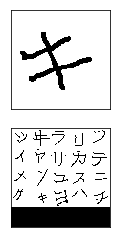

In [6]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)


In [ ]:
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 90000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            siamese_net.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))


!
training
4.5167255
current accuracy on random data of 250 samples : 16.4
4.4780436
current accuracy on random data of 250 samples : 24.4
4.4453464
current accuracy on random data of 250 samples : 27.6
4.430765
current accuracy on random data of 250 samples : 28.8
4.4227476
current accuracy on random data of 250 samples : 32.4
4.3911805
current accuracy on random data of 250 samples : 31.2
4.3432264
current accuracy on random data of 250 samples : 31.6
4.314102
current accuracy on random data of 250 samples : 34.8
4.3036594
current accuracy on random data of 250 samples : 34.0
4.2847095
current accuracy on random data of 250 samples : 38.8
4.284258
current accuracy on random data of 250 samples : 34.8
4.2688346
current accuracy on random data of 250 samples : 34.4
4.195536
current accuracy on random data of 250 samples : 28.0
4.142962
current accuracy on random data of 250 samples : 26.8
4.188252
current accuracy on random data of 250 samples : 26.4
4.121494
current accuracy on random

2.7553294
current accuracy on random data of 250 samples : 28.4
2.702459
current accuracy on random data of 250 samples : 32.0
2.767849
current accuracy on random data of 250 samples : 24.4
2.7177806
current accuracy on random data of 250 samples : 32.0
2.6116824
current accuracy on random data of 250 samples : 30.0
2.7888172
current accuracy on random data of 250 samples : 25.6
2.67958
current accuracy on random data of 250 samples : 17.6
2.6514168
current accuracy on random data of 250 samples : 20.4
2.6097846
current accuracy on random data of 250 samples : 21.2
2.5365078
current accuracy on random data of 250 samples : 27.6
2.7455347
current accuracy on random data of 250 samples : 18.8
2.630867
current accuracy on random data of 250 samples : 18.4
2.600126
current accuracy on random data of 250 samples : 21.6
2.606538
current accuracy on random data of 250 samples : 24.0
2.4630404
current accuracy on random data of 250 samples : 24.0
2.6633623
current accuracy on random data of 25

2.027084
current accuracy on random data of 250 samples : 34.8
2.019195
current accuracy on random data of 250 samples : 29.2
1.8865006
current accuracy on random data of 250 samples : 31.6
2.0079458
current accuracy on random data of 250 samples : 27.2
2.2113867
current accuracy on random data of 250 samples : 36.0
2.0514517
current accuracy on random data of 250 samples : 33.6
1.9766135
current accuracy on random data of 250 samples : 35.6
2.017573
current accuracy on random data of 250 samples : 42.4
2.0742977
current accuracy on random data of 250 samples : 36.4
2.0740948
current accuracy on random data of 250 samples : 39.2
2.0548694
current accuracy on random data of 250 samples : 40.8
1.9676111
current accuracy on random data of 250 samples : 28.4
1.9415177
current accuracy on random data of 250 samples : 38.4
2.0108545
current accuracy on random data of 250 samples : 29.2
1.8908637
current accuracy on random data of 250 samples : 41.2
2.038055
current accuracy on random data of

1.6383721
current accuracy on random data of 250 samples : 42.4
1.7606549
current accuracy on random data of 250 samples : 42.4
1.6734229
current accuracy on random data of 250 samples : 40.4
1.7517612
current accuracy on random data of 250 samples : 40.0
1.6174875
current accuracy on random data of 250 samples : 38.0
1.7237915
current accuracy on random data of 250 samples : 38.0
1.7981449
current accuracy on random data of 250 samples : 41.6
1.6873991
current accuracy on random data of 250 samples : 41.2
1.6322428
current accuracy on random data of 250 samples : 39.6
1.5374537
current accuracy on random data of 250 samples : 42.8
1.6431203
current accuracy on random data of 250 samples : 35.6
1.5458513
current accuracy on random data of 250 samples : 41.2
1.6091229
current accuracy on random data of 250 samples : 40.0
1.6468658
current accuracy on random data of 250 samples : 45.6
1.6423346
current accuracy on random data of 250 samples : 42.8
1.7474688
current accuracy on random dat

1.2462243
current accuracy on random data of 250 samples : 47.6
1.3459935
current accuracy on random data of 250 samples : 46.0
1.3343289
current accuracy on random data of 250 samples : 42.0
1.4299774
current accuracy on random data of 250 samples : 45.2
1.4875741
current accuracy on random data of 250 samples : 39.6
1.4050679
current accuracy on random data of 250 samples : 41.6
1.4673322
current accuracy on random data of 250 samples : 38.8
1.4581215
current accuracy on random data of 250 samples : 41.6
1.3076334
current accuracy on random data of 250 samples : 41.2
1.401096
current accuracy on random data of 250 samples : 49.6
1.5539808
current accuracy on random data of 250 samples : 44.0
1.3980227
current accuracy on random data of 250 samples : 45.6
1.3811144
current accuracy on random data of 250 samples : 45.6
1.3411435
current accuracy on random data of 250 samples : 42.4
1.5164251
current accuracy on random data of 250 samples : 43.2
1.5036302
current accuracy on random data

current accuracy on random data of 250 samples : 54.0
1.3124539
current accuracy on random data of 250 samples : 52.4
1.2321459
current accuracy on random data of 250 samples : 46.4
1.2629565
current accuracy on random data of 250 samples : 55.6
1.2785301
current accuracy on random data of 250 samples : 47.2
1.2656778
current accuracy on random data of 250 samples : 57.6
1.3348958
current accuracy on random data of 250 samples : 58.8
1.2082541
current accuracy on random data of 250 samples : 52.8
1.2128731
current accuracy on random data of 250 samples : 57.6
1.2591978
current accuracy on random data of 250 samples : 50.8
1.3298849
current accuracy on random data of 250 samples : 52.8
1.3524996
current accuracy on random data of 250 samples : 48.4
1.3681513
current accuracy on random data of 250 samples : 50.4
iteration 650, training loss: 1.37,
1.3452137
current accuracy on random data of 250 samples : 49.6
1.2980089
current accuracy on random data of 250 samples : 44.8
1.1131967
curr

1.0242944
current accuracy on random data of 250 samples : 49.2
1.2618088
current accuracy on random data of 250 samples : 51.2
1.0406065
current accuracy on random data of 250 samples : 52.4
1.1122583
current accuracy on random data of 250 samples : 51.2
1.0239424
current accuracy on random data of 250 samples : 49.2
1.2262518
current accuracy on random data of 250 samples : 52.4
1.0238578
current accuracy on random data of 250 samples : 50.8
0.9869626
current accuracy on random data of 250 samples : 48.0
1.0652695
current accuracy on random data of 250 samples : 48.4
1.0683672
current accuracy on random data of 250 samples : 51.2
0.9976394
current accuracy on random data of 250 samples : 49.6
1.0280118
current accuracy on random data of 250 samples : 48.4
1.1721343
current accuracy on random data of 250 samples : 52.8
1.1158015
current accuracy on random data of 250 samples : 50.0
0.98319894
current accuracy on random data of 250 samples : 48.0
1.0754315
current accuracy on random da

1.0713627
current accuracy on random data of 250 samples : 55.6
1.1341746
current accuracy on random data of 250 samples : 56.8
0.97857606
current accuracy on random data of 250 samples : 62.4
1.0608478
current accuracy on random data of 250 samples : 53.6
0.9217128
current accuracy on random data of 250 samples : 56.8
0.8661009
current accuracy on random data of 250 samples : 56.8
0.941419
current accuracy on random data of 250 samples : 53.6
0.9378033
current accuracy on random data of 250 samples : 54.4
0.9807263
current accuracy on random data of 250 samples : 56.8
iteration 900, training loss: 0.98,
0.88098836
current accuracy on random data of 250 samples : 51.2
0.92761034
current accuracy on random data of 250 samples : 53.6
0.9165559
current accuracy on random data of 250 samples : 54.4
1.038052
current accuracy on random data of 250 samples : 52.8
0.920274
current accuracy on random data of 250 samples : 53.6
0.93038917
current accuracy on random data of 250 samples : 58.8
0.9

1.0463605
current accuracy on random data of 250 samples : 57.6
1.0212673
current accuracy on random data of 250 samples : 58.8
0.96178037
current accuracy on random data of 250 samples : 60.0
0.8524325
current accuracy on random data of 250 samples : 56.0
0.91548604
current accuracy on random data of 250 samples : 56.0
0.8813494
current accuracy on random data of 250 samples : 56.4
0.82491845
current accuracy on random data of 250 samples : 58.0
0.9593553
current accuracy on random data of 250 samples : 57.6
0.91326886
current accuracy on random data of 250 samples : 55.2
1.10939
current accuracy on random data of 250 samples : 61.6
1.0067222
current accuracy on random data of 250 samples : 58.8
1.0076333
current accuracy on random data of 250 samples : 54.8
0.99602664
current accuracy on random data of 250 samples : 48.4
0.78183556
current accuracy on random data of 250 samples : 53.6
0.9618237
current accuracy on random data of 250 samples : 48.8
0.87984455
current accuracy on rando

0.8153347
current accuracy on random data of 250 samples : 58.8
0.8218096
current accuracy on random data of 250 samples : 54.8
0.9505985
current accuracy on random data of 250 samples : 58.8
0.84979904
current accuracy on random data of 250 samples : 42.4
0.88723207
current accuracy on random data of 250 samples : 52.8
0.90906054
current accuracy on random data of 250 samples : 47.6
iteration 1150, training loss: 0.91,
0.7559202
current accuracy on random data of 250 samples : 55.2
0.87888885
current accuracy on random data of 250 samples : 56.0
0.95284456
current accuracy on random data of 250 samples : 52.8
0.87704813
current accuracy on random data of 250 samples : 57.6
0.8211399
current accuracy on random data of 250 samples : 56.0
0.9442468
current accuracy on random data of 250 samples : 57.6
0.92416304
current accuracy on random data of 250 samples : 56.4
0.896242
current accuracy on random data of 250 samples : 57.6
0.87680745
current accuracy on random data of 250 samples : 6

0.80258906
current accuracy on random data of 250 samples : 56.8
1.0062869
current accuracy on random data of 250 samples : 58.8
0.66078407
current accuracy on random data of 250 samples : 61.2
0.7792805
current accuracy on random data of 250 samples : 54.4
0.9149173
current accuracy on random data of 250 samples : 63.2
0.9351508
current accuracy on random data of 250 samples : 65.6
0.8896723
current accuracy on random data of 250 samples : 58.8
0.7610549
current accuracy on random data of 250 samples : 59.6
0.99488175
current accuracy on random data of 250 samples : 60.4
0.73487324
current accuracy on random data of 250 samples : 62.0
0.70455015
current accuracy on random data of 250 samples : 65.6
0.81087947
current accuracy on random data of 250 samples : 55.2
0.7290871
current accuracy on random data of 250 samples : 64.0
0.8227263
current accuracy on random data of 250 samples : 61.2
0.78207415
current accuracy on random data of 250 samples : 58.4
0.78975093
current accuracy on ra

0.7733929
current accuracy on random data of 250 samples : 58.8
0.88155246
current accuracy on random data of 250 samples : 63.6
0.71243423
current accuracy on random data of 250 samples : 61.6
iteration 1400, training loss: 0.71,
0.78598756
current accuracy on random data of 250 samples : 62.4
0.8700875
current accuracy on random data of 250 samples : 60.0
0.87042946
current accuracy on random data of 250 samples : 66.0
0.92310107
current accuracy on random data of 250 samples : 64.0
0.81720173
current accuracy on random data of 250 samples : 63.2
0.7521646
current accuracy on random data of 250 samples : 61.6
0.6790195
current accuracy on random data of 250 samples : 60.0
0.93787616
current accuracy on random data of 250 samples : 64.4
0.68794805
current accuracy on random data of 250 samples : 60.8
0.9477652
current accuracy on random data of 250 samples : 61.2
0.7009676
current accuracy on random data of 250 samples : 63.2
0.7426506
current accuracy on random data of 250 samples : 

0.71443355
current accuracy on random data of 250 samples : 58.8
0.7417338
current accuracy on random data of 250 samples : 60.0
0.73202527
current accuracy on random data of 250 samples : 58.4
0.6409898
current accuracy on random data of 250 samples : 62.0
0.6766329
current accuracy on random data of 250 samples : 65.6
0.7272002
current accuracy on random data of 250 samples : 67.2
0.6810257
current accuracy on random data of 250 samples : 60.0
0.772094
current accuracy on random data of 250 samples : 64.8
0.73685616
current accuracy on random data of 250 samples : 61.2
0.6824715
current accuracy on random data of 250 samples : 67.2
0.5997153
current accuracy on random data of 250 samples : 60.0
0.83551913
current accuracy on random data of 250 samples : 67.6
0.7143235
current accuracy on random data of 250 samples : 62.4
0.6163121
current accuracy on random data of 250 samples : 63.2
0.90641356
current accuracy on random data of 250 samples : 69.2
0.5712755
current accuracy on random

0.5952588
current accuracy on random data of 250 samples : 71.2
0.73419404
current accuracy on random data of 250 samples : 64.4
0.68129563
current accuracy on random data of 250 samples : 60.8
0.7781608
current accuracy on random data of 250 samples : 60.4
0.6981843
current accuracy on random data of 250 samples : 66.8
0.6207575
current accuracy on random data of 250 samples : 62.8
0.766992
current accuracy on random data of 250 samples : 64.8
0.5912932
current accuracy on random data of 250 samples : 62.0
0.8098374
current accuracy on random data of 250 samples : 57.6
0.67206544
current accuracy on random data of 250 samples : 56.8
0.6619942
current accuracy on random data of 250 samples : 53.6
0.82335716
current accuracy on random data of 250 samples : 60.8
0.8237773
current accuracy on random data of 250 samples : 59.2
0.7582956
current accuracy on random data of 250 samples : 59.2
0.65311366
current accuracy on random data of 250 samples : 64.8
0.8388828
current accuracy on random

current accuracy on random data of 250 samples : 61.2
0.6635209
current accuracy on random data of 250 samples : 67.2
0.65254605
current accuracy on random data of 250 samples : 59.6
0.6331131
current accuracy on random data of 250 samples : 61.6
0.8480256
current accuracy on random data of 250 samples : 66.8
0.631313
current accuracy on random data of 250 samples : 64.0
0.626133
current accuracy on random data of 250 samples : 62.0
0.7191353
current accuracy on random data of 250 samples : 61.2
0.6726484
current accuracy on random data of 250 samples : 56.0
0.7199017
current accuracy on random data of 250 samples : 59.2
0.69270355
current accuracy on random data of 250 samples : 58.4
0.8465257
current accuracy on random data of 250 samples : 56.8
0.57921743
current accuracy on random data of 250 samples : 60.8
0.71566236
current accuracy on random data of 250 samples : 54.0
0.6247924
current accuracy on random data of 250 samples : 53.6
0.7619477
current accuracy on random data of 250

0.5515807
current accuracy on random data of 250 samples : 68.0
0.53936493
current accuracy on random data of 250 samples : 62.4
0.54572016
current accuracy on random data of 250 samples : 62.8
0.5347163
current accuracy on random data of 250 samples : 69.6
0.7724396
current accuracy on random data of 250 samples : 66.4
0.68418914
current accuracy on random data of 250 samples : 67.6
0.57089937
current accuracy on random data of 250 samples : 66.4
0.5718403
current accuracy on random data of 250 samples : 65.2
0.7715007
current accuracy on random data of 250 samples : 62.8
0.6646023
current accuracy on random data of 250 samples : 67.6
0.7010031
current accuracy on random data of 250 samples : 65.2
0.5703075
current accuracy on random data of 250 samples : 66.4
0.62723815
current accuracy on random data of 250 samples : 57.2
0.5795116
current accuracy on random data of 250 samples : 57.2
0.74104214
current accuracy on random data of 250 samples : 59.2
0.71661305
current accuracy on ran

current accuracy on random data of 250 samples : 64.8
0.5390471
current accuracy on random data of 250 samples : 58.8
0.660942
current accuracy on random data of 250 samples : 66.0
0.6675413
current accuracy on random data of 250 samples : 66.4
0.508135
current accuracy on random data of 250 samples : 63.2
0.55922145
current accuracy on random data of 250 samples : 66.0
0.6002844
current accuracy on random data of 250 samples : 64.4
0.61094266
current accuracy on random data of 250 samples : 61.6
0.5415565
current accuracy on random data of 250 samples : 64.8
0.61120725
current accuracy on random data of 250 samples : 62.0
0.5946199
current accuracy on random data of 250 samples : 65.6
0.5849104
current accuracy on random data of 250 samples : 64.8
0.6244101
current accuracy on random data of 250 samples : 65.6
0.57669425
current accuracy on random data of 250 samples : 58.4
0.47443113
current accuracy on random data of 250 samples : 62.4
0.6160786
current accuracy on random data of 25

0.45317537
current accuracy on random data of 250 samples : 67.2
0.6372423
current accuracy on random data of 250 samples : 64.0
0.58618784
current accuracy on random data of 250 samples : 63.2
0.6410643
current accuracy on random data of 250 samples : 68.0
0.6200844
current accuracy on random data of 250 samples : 67.2
0.7226661
current accuracy on random data of 250 samples : 60.4
0.7817917
current accuracy on random data of 250 samples : 66.8
0.5798446
current accuracy on random data of 250 samples : 63.6
0.47551623
current accuracy on random data of 250 samples : 64.0
0.5067892
current accuracy on random data of 250 samples : 63.6
0.6698892
current accuracy on random data of 250 samples : 63.2
0.6068161
current accuracy on random data of 250 samples : 66.0
0.6111031
current accuracy on random data of 250 samples : 66.0
0.5401404
current accuracy on random data of 250 samples : 64.4
0.6424788
current accuracy on random data of 250 samples : 63.6
0.57523656
current accuracy on random

0.4684945
current accuracy on random data of 250 samples : 61.6
0.53696865
current accuracy on random data of 250 samples : 69.6
0.46042523
current accuracy on random data of 250 samples : 66.8
0.55651164
current accuracy on random data of 250 samples : 66.4
0.5258782
current accuracy on random data of 250 samples : 66.0
0.5800075
current accuracy on random data of 250 samples : 65.2
0.71041185
current accuracy on random data of 250 samples : 68.0
0.5641465
current accuracy on random data of 250 samples : 68.0
0.5799147
current accuracy on random data of 250 samples : 68.4
0.7500865
current accuracy on random data of 250 samples : 65.6
0.48768806
current accuracy on random data of 250 samples : 71.2
0.650342
current accuracy on random data of 250 samples : 70.0
0.5684866
current accuracy on random data of 250 samples : 70.0
0.580034
current accuracy on random data of 250 samples : 66.0
0.4882488
current accuracy on random data of 250 samples : 66.8
0.5673369
current accuracy on random 

0.5099847
current accuracy on random data of 250 samples : 65.2
0.5802596
current accuracy on random data of 250 samples : 66.8
0.4588362
current accuracy on random data of 250 samples : 70.8
0.46367806
current accuracy on random data of 250 samples : 66.4
0.4372624
current accuracy on random data of 250 samples : 63.6
0.50457174
current accuracy on random data of 250 samples : 64.0
0.48317087
current accuracy on random data of 250 samples : 69.2
0.5399311
current accuracy on random data of 250 samples : 69.6
0.65349764
current accuracy on random data of 250 samples : 68.4
0.46983817
current accuracy on random data of 250 samples : 60.8
0.50087804
current accuracy on random data of 250 samples : 66.0
0.52494746
current accuracy on random data of 250 samples : 79.2
0.57571167
current accuracy on random data of 250 samples : 70.0
0.7343609
current accuracy on random data of 250 samples : 61.2
0.65389764
current accuracy on random data of 250 samples : 72.8
0.57917017
current accuracy on 

0.5516434
current accuracy on random data of 250 samples : 62.4
0.6951334
current accuracy on random data of 250 samples : 67.6
0.48299226
current accuracy on random data of 250 samples : 65.6
0.4874913
current accuracy on random data of 250 samples : 69.6
0.71684384
current accuracy on random data of 250 samples : 64.4
0.41917333
current accuracy on random data of 250 samples : 77.2
0.57502186
current accuracy on random data of 250 samples : 69.2
0.47464663
current accuracy on random data of 250 samples : 69.6
0.49151734
current accuracy on random data of 250 samples : 62.8
0.5186782
current accuracy on random data of 250 samples : 67.2
0.5781818
current accuracy on random data of 250 samples : 62.8
0.49570936
current accuracy on random data of 250 samples : 61.6
0.693181
current accuracy on random data of 250 samples : 66.4
0.6548009
current accuracy on random data of 250 samples : 66.8
0.45332742
current accuracy on random data of 250 samples : 60.0
0.49168435
current accuracy on ra

0.5069235
current accuracy on random data of 250 samples : 66.8
0.44922617
current accuracy on random data of 250 samples : 69.6
0.7048934
current accuracy on random data of 250 samples : 58.0
0.48934773
current accuracy on random data of 250 samples : 72.8
0.44190007
current accuracy on random data of 250 samples : 68.8
0.5042908
current accuracy on random data of 250 samples : 64.4
0.3789855
current accuracy on random data of 250 samples : 64.0
0.45676163
current accuracy on random data of 250 samples : 72.8
0.6673307
current accuracy on random data of 250 samples : 65.6
0.6253677
current accuracy on random data of 250 samples : 75.6
0.5178022
current accuracy on random data of 250 samples : 71.6
0.57923657
current accuracy on random data of 250 samples : 67.2
0.40802318
current accuracy on random data of 250 samples : 70.0
0.5597838
current accuracy on random data of 250 samples : 72.0
0.49333656
current accuracy on random data of 250 samples : 68.0
0.4782838
current accuracy on ran

0.5123935
current accuracy on random data of 250 samples : 65.6
0.45513916
current accuracy on random data of 250 samples : 66.4
0.46218196
current accuracy on random data of 250 samples : 70.4
0.37882555
current accuracy on random data of 250 samples : 63.6
0.4428823
current accuracy on random data of 250 samples : 68.8
0.4948699
current accuracy on random data of 250 samples : 66.8
0.51444983
current accuracy on random data of 250 samples : 66.8
0.6052265
current accuracy on random data of 250 samples : 71.2
0.40698105
current accuracy on random data of 250 samples : 71.6
0.560175
current accuracy on random data of 250 samples : 68.0
0.48217428
current accuracy on random data of 250 samples : 66.8
0.45050377
current accuracy on random data of 250 samples : 68.4
0.5218946
current accuracy on random data of 250 samples : 68.4
0.5564771
current accuracy on random data of 250 samples : 66.8
0.4154198
current accuracy on random data of 250 samples : 69.6
iteration 2800, training loss: 0.4

0.54645306
current accuracy on random data of 250 samples : 61.6
0.48979062
current accuracy on random data of 250 samples : 65.6
0.53027964
current accuracy on random data of 250 samples : 67.2
0.35336727
current accuracy on random data of 250 samples : 67.6
0.4510821
current accuracy on random data of 250 samples : 60.0
0.6303845
current accuracy on random data of 250 samples : 71.2
0.45677173
current accuracy on random data of 250 samples : 72.4
0.37641993
current accuracy on random data of 250 samples : 72.8
0.48800957
current accuracy on random data of 250 samples : 72.0
0.4659566
current accuracy on random data of 250 samples : 68.4
0.4157933
current accuracy on random data of 250 samples : 74.0
0.36500603
current accuracy on random data of 250 samples : 64.0
0.47479826
current accuracy on random data of 250 samples : 76.0
0.45146552
current accuracy on random data of 250 samples : 69.6
0.74290013
current accuracy on random data of 250 samples : 67.6
0.6173923
current accuracy on

0.6860708
current accuracy on random data of 250 samples : 66.0
0.5020708
current accuracy on random data of 250 samples : 68.0
0.53172374
current accuracy on random data of 250 samples : 66.8
0.3991829
current accuracy on random data of 250 samples : 72.8
0.41231838
current accuracy on random data of 250 samples : 67.6
0.34656417
current accuracy on random data of 250 samples : 69.6
0.48826963
current accuracy on random data of 250 samples : 65.2
0.5340228
current accuracy on random data of 250 samples : 66.4
0.4380368
current accuracy on random data of 250 samples : 67.6
0.39850006
current accuracy on random data of 250 samples : 64.4
0.40721187
current accuracy on random data of 250 samples : 68.8
0.46456265
current accuracy on random data of 250 samples : 66.0
0.4156607
current accuracy on random data of 250 samples : 63.6
iteration 3050, training loss: 0.42,
0.3919226
current accuracy on random data of 250 samples : 68.4
0.4870306
current accuracy on random data of 250 samples : 6

0.4274799
current accuracy on random data of 250 samples : 67.6
0.33360773
current accuracy on random data of 250 samples : 72.8
0.34793028
current accuracy on random data of 250 samples : 70.4
0.4289446
current accuracy on random data of 250 samples : 73.6
0.3765142
current accuracy on random data of 250 samples : 75.2
0.48437986
current accuracy on random data of 250 samples : 71.2
0.40045336
current accuracy on random data of 250 samples : 73.2
0.45309314
current accuracy on random data of 250 samples : 70.8
0.42327526
current accuracy on random data of 250 samples : 68.0
0.45207667
current accuracy on random data of 250 samples : 71.2
0.3867258
current accuracy on random data of 250 samples : 71.2
0.4314087
current accuracy on random data of 250 samples : 74.0
0.39164034
current accuracy on random data of 250 samples : 66.4
0.52157706
current accuracy on random data of 250 samples : 72.0
0.462941
current accuracy on random data of 250 samples : 66.4
0.38408032
current accuracy on r

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [ ]:

a=test_nn_accuracy(3,500,loader)
print(a)